# Working with CMEMS data

This notebook is focused on the finite-difference computation of quantities derived from CMEMS data.

The model is MIOST and the simulation is called reanalysis. MIOST is the code that solves the primitive equations and many other things like sea ice. Please visit [http://duacs.cls.fr](http://duacs.cls.fr). The specific configuration of the DUACS and AVISO models can vary depending on several factors, including spatial and temporal resolution, physical parameters, external forcings, data assimilation, submarine topography, etc.
The data file used here contains surface variables $ugosa$, $vgosa$, $Sla$, with a resolution of 0.25°*0.25°.

## Import packages

The package called ```utils``` is a local. It contains useful functions, and functions to be completed when requested.

In [4]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
import utils as ut
import netCDF4 as nc
import netCDF4

## File location and name

In [5]:
data = xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1713524113026.nc')
data

<xarray.Dataset>
Dimensions:    (time: 158, latitude: 160, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 -19.88 -19.62 -19.38 ... 19.38 19.62 19.88
  * longitude  (longitude) float32 -69.88 -69.62 -69.38 ... 19.38 19.62 19.88
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-06-07
Data variables:
    adt        (time, latitude, longitude) float32 ...
    sla        (time, latitude, longitude) float32 ...
    ugos       (time, latitude, longitude) float32 ...
    ugosa      (time, latitude, longitude) float32 ...
    vgos       (time, latitude, longitude) float32 ...
    vgosa      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:             DT merged all satellites Global Ocean Gridded SSALTO/D...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2021-07-26 19:51:56Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SEALEVEL_GLO_PHY_L4_MY_008_047
    subset:datasetId:  cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1...
    subset:date:       2024-04-19T10:55:13.026Z

## Read data

In [6]:
ds_W = data
u_curr = np.mean(ds_W.variables['ugosa'][:], axis=0)
v_curr = np.mean(ds_W.variables['vgosa'][:], axis=0)
sla = np.mean(ds_W.variables['sla'][:], axis=0)
adt = np.mean(ds_W.variables['adt'][:], axis=0)
lon = ds_W.variables['longitude'][:]
lat = ds_W.variables['latitude'][:]
lon_1, lat_1 = np.meshgrid(lon,lat)

 The Sea Surface Height (SSH) can be calculated from the Sea Level Anomaly (SLA) by adding the mean sea level to the SLA. The SLA represents the fluctuations of the sea level relative to a long-term average, while the SSH is the height of the sea surface relative to a reference geoid.

Here's how to calculate the SSH from the SLA:
$SSH=SLA+ Sea-Surface-Height-Above-Geoid$

In [7]:
ssh = sla+adt

## Plot

We define functions to facilitate plotting, then plot $u$, $v$, and $SSH$.

In [8]:
def _plot(ax,var,title):
    ax.set_title(title)
    im = ax.pcolormesh(lon,lat,var,shading='auto')
    plt.colorbar(im,ax=ax)
    
def plot(u,v,ssh):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    ax1.set_ylabel('latitude')
    for ax in (ax1,ax2,ax3):
        ax.set_xlabel('longitude')
    _plot(ax1,u,'Field 1')
    _plot(ax2,v,'Field 2')
    _plot(ax3,ssh,'Field 3')
    return fig

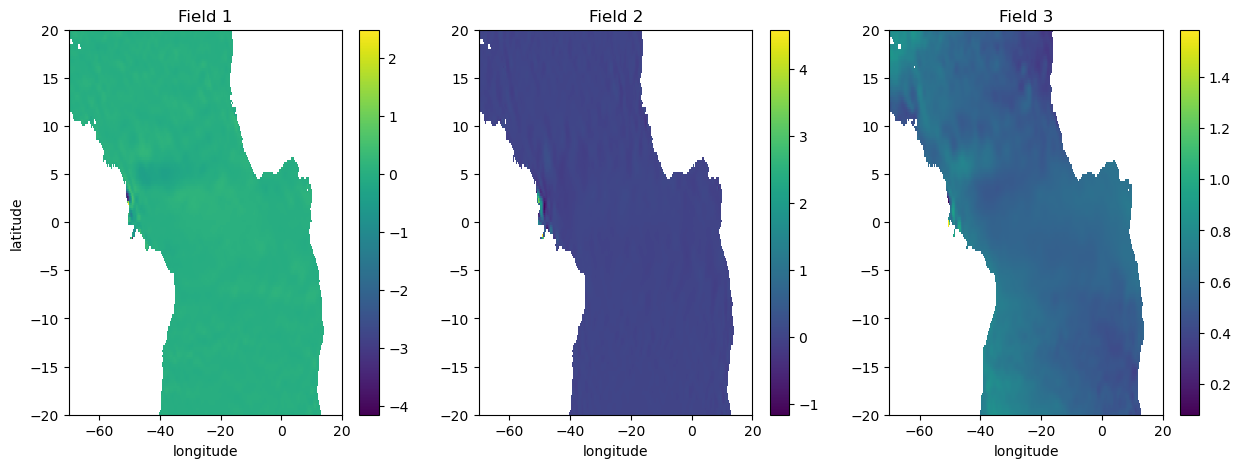

In [9]:
fig = plot(u_curr,v_curr,ssh)

## Geostrophic velocity

Here we want to compute the geostrophic current velocity from $SSH$. The formulas are recalled:

$$ u_{geos} = -\frac{g}{f}\frac{\partial SSH}{\partial y} $$
$$ v_{geos} =  \frac{g}{f}\frac{\partial SSH}{\partial x} $$

First, the gravity constant and the Coriolis factor are defined.

In [10]:
# Local parameters
gravity = 9.81
coriolis_factor = 2 * 7.2722e-05 * np.sin(lat_1*np.pi/180)

Then the gradient of $SSH$ is computed using the appropriate function in the ```utils``` package, then the geostrophic velocities.

In [11]:
gradx_ssh, grady_ssh = ut.gradient(ssh, lon_1, lat_1)
u_geos = - gravity * grady_ssh / coriolis_factor
v_geos =   gravity * gradx_ssh / coriolis_factor

In [12]:
## Using the linear approximation to correct the Coriolis parameter at the equator.

In [44]:
import numpy as np

def coriolis_parameter(latitude, latitude_ref, omega):
    """
    Calcul du paramètre de Coriolis en fonction de la latitude à l'aide de l'approximation linéaire.
    
    Paramètres :
        - latitude : Vecteur de latitudes en degrés.
        - latitude_ref : Latitude de référence en degrés.
        - omega : Vitesse angulaire de la Terre en rad/s.
    
    Retourne :
        - Paramètres de Coriolis en fonction des latitudes.
    """
    # Filtrer les latitudes entre -1 et 1 degré
    latitudes_filtrees =np.where((latitudes > -0.5) & (latitudes < 0.5), np.nan, latitudes)
    
    # Calculer les paramètres de Coriolis uniquement pour les latitudes filtrées
    return 2 * omega * np.sin(np.radians(latitude_ref)) + (latitudes_filtrees - latitude_ref) * (2 * omega * np.cos(np.radians(latitude_ref)))

# Exemple d'utilisation
latitude_ref = 45  # Latitude de référence en degrés
omega = 7.2921159e-5  # Vitesse angulaire de la Terre en rad/s

# Vecteur de latitudes à évaluer
latitudes = lat_1

# Calcul des paramètres de Coriolis à l'aide de l'approximation linéaire
coriolis_factor = coriolis_parameter(latitudes, latitude_ref, omega)

gradx_ssh, grady_ssh = ut.gradient(ssh, lon_1, lat_1) 
u_geos_1 = - gravity * grady_ssh / coriolis_factor
v_geos_1 =   gravity * gradx_ssh / coriolis_factor

#  print("Paramètres de Coriolis aux latitudes", latitudes, ":", parametres_coriolis)

Below we plot the full zonal current, the zonal geostrophic current, and the difference between the two.

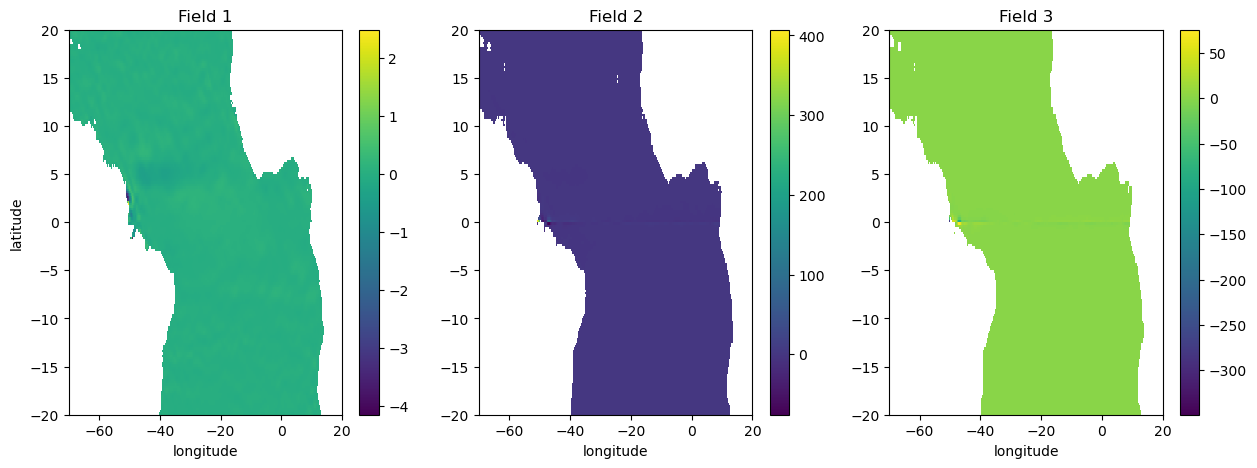

In [14]:
fig = plot(u_curr,u_geos,u_curr-u_geos)

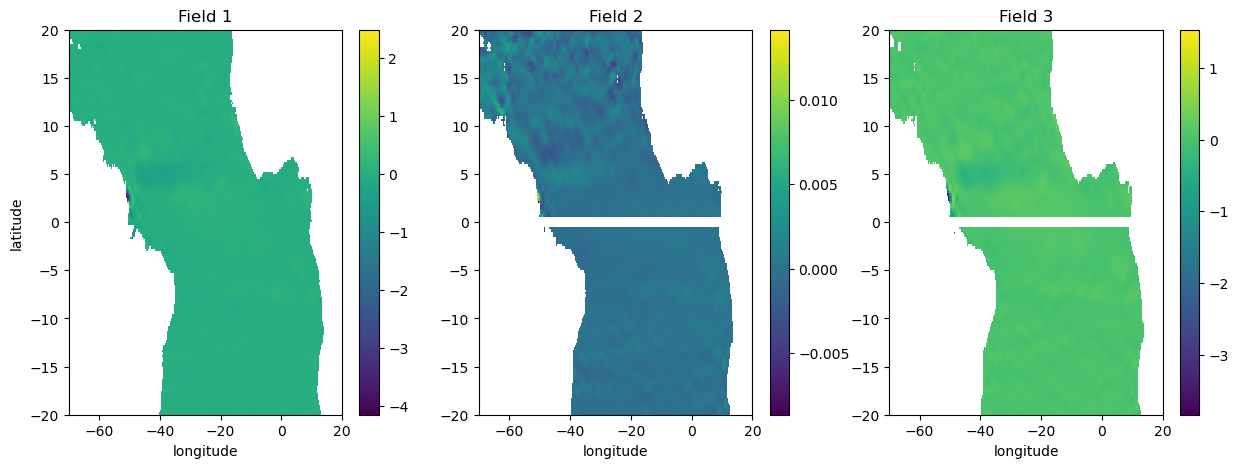

In [15]:
fig = plot(u_curr,u_geos_1,u_curr-u_geos_1)

Same with meridional currents.

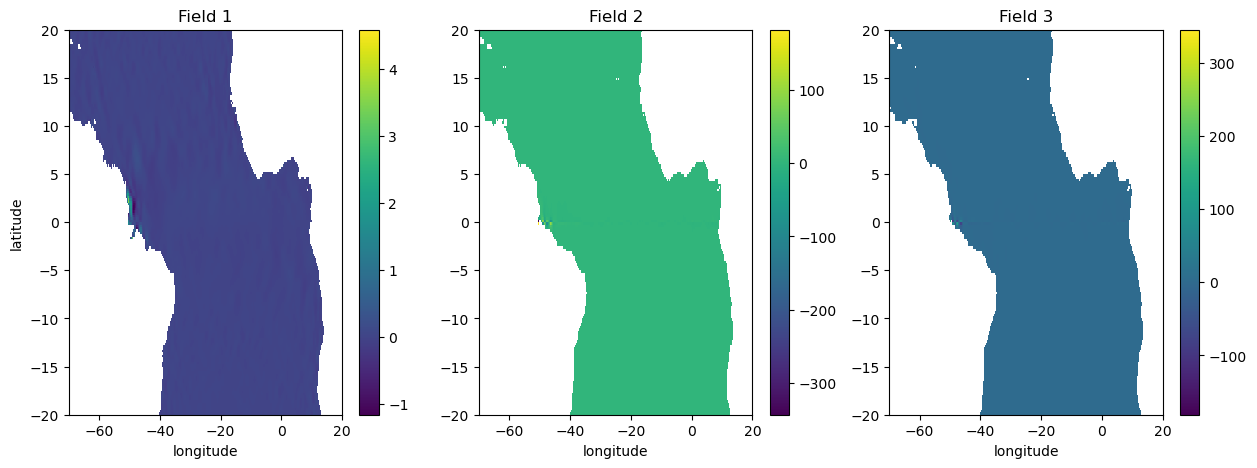

In [16]:
fig = plot(v_curr,v_geos,v_curr-v_geos)

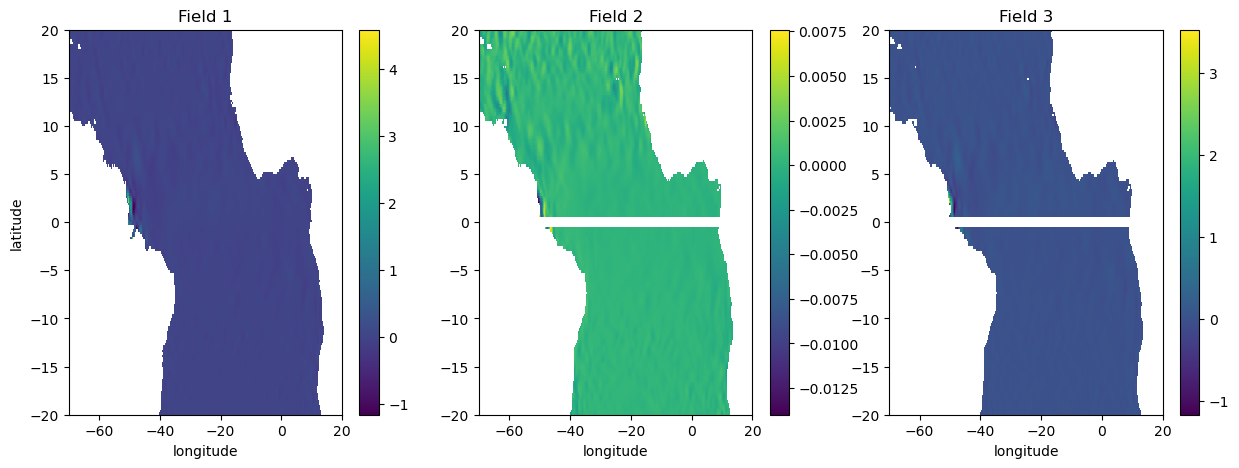

In [17]:
fig = plot(v_curr,v_geos_1,v_curr-v_geos_1)

### QUESTIONS

* Does geostrophy dominate the flow?
* Are the other components velocity negligible? 

## Divergence of velocity fields

Below the divergences of current velocity and geostrophic current velocity are computed.

In [18]:
div_uv = ut.divergence(u_curr, v_curr, lon_1, lat_1)
div_geos = ut.divergence(u_geos, v_geos, lon_1, lat_1)

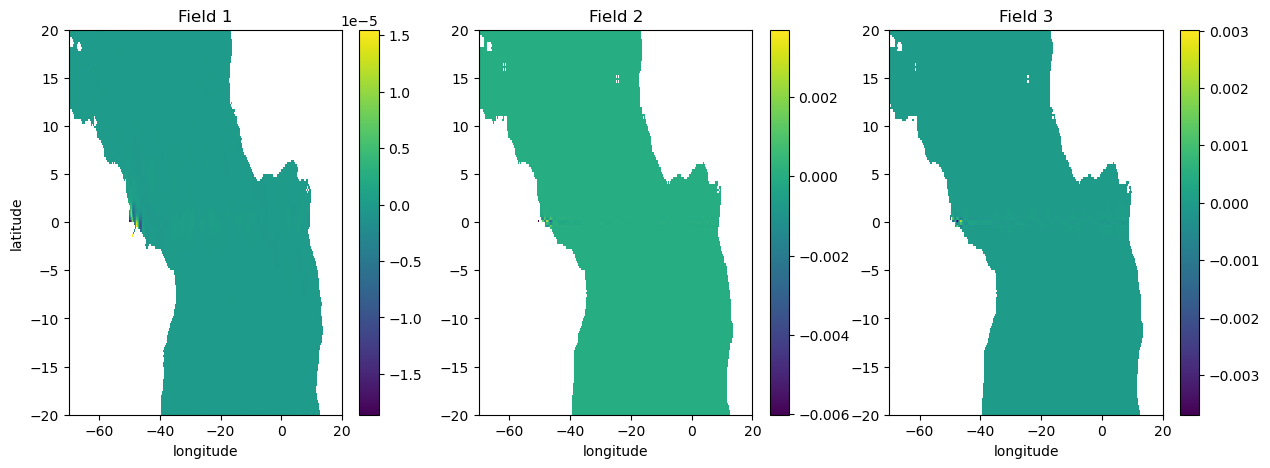

In [19]:
fig = plot(div_uv,div_geos,div_uv-div_geos)

In [20]:
div_uv = ut.divergence(u_curr, v_curr, lon_1, lat_1)
div_geos = ut.divergence(u_geos_1, v_geos_1, lon_1, lat_1)

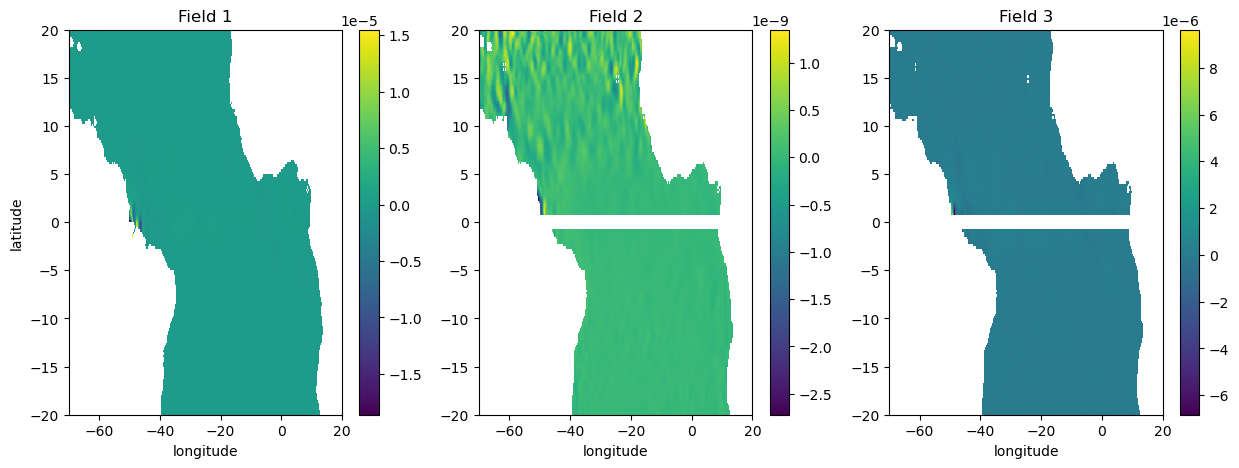

In [21]:
fig = plot(div_uv,div_geos,div_uv-div_geos)

### QUESTIONS

* How do you explain that the divergence of geostrophic velocity is several orders of magnitude lower than the other one?
* A look at the code: Describe in technical details what the ```derivative``` function in ```utils``` does exactly.

## Vorticity

### QUESTION

In the cell below, code the calculation of vorticity for both velocity fields.

In [22]:
vort_uv = ut.rotational(u_curr, v_curr, lon_1, lat_1)   # change this!
vort_geos = ut.rotational(u_curr, v_curr, lon_1, lat_1)  # change this!

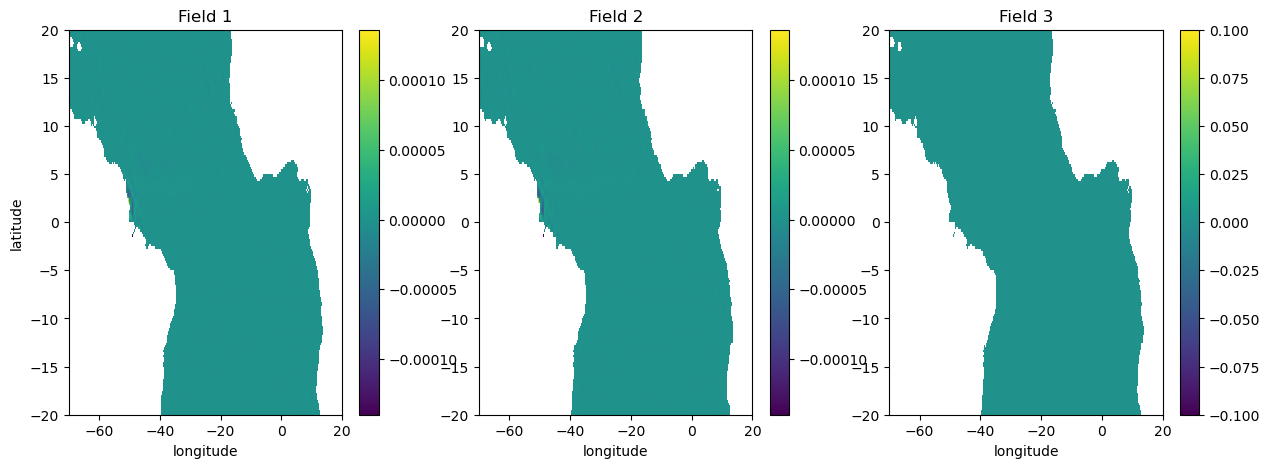

In [23]:
fig = plot(vort_uv,vort_geos,vort_uv-vort_geos)

## Advection terms

To check whether the difference between the full velocity and the geostrophic velocity is due to the advection terms, we compute these terms below. If this was the case, it would mean that the flow is close to cyclogeostrophy, described by the following equations:

$$ \frac{1}{f}({\bf u}.\nabla)u - v = -v_{geos} $$

$$ \frac{1}{f}({\bf u}.\nabla)v + u =  u_{geos} $$

rewritten as:

$$ v = \frac{1}{f}({\bf u}.\nabla)u + v_{geos} $$

$$ u = - \frac{1}{f}({\bf u}.\nabla)v +  u_{geos} $$

Here, ${\bf u} = (u,v)$ is the velocity vector with zonal and meridional components $u$ and $v$. To learn more about the cyclogeostrophic balance, please refer to <https://archimer.ifremer.fr/doc/00175/28617/27045.pdf>. 

### QUESTION

* Describe what the ```advection``` function computes exactly.
* Compute the advection terms for $u$ and $v$ (divided by the coriolis factor).
* Design appropriate plots to check whether the cyclogeostrophic balance is verified, or not.

In [24]:
advec_u, advec_v = 1, 1

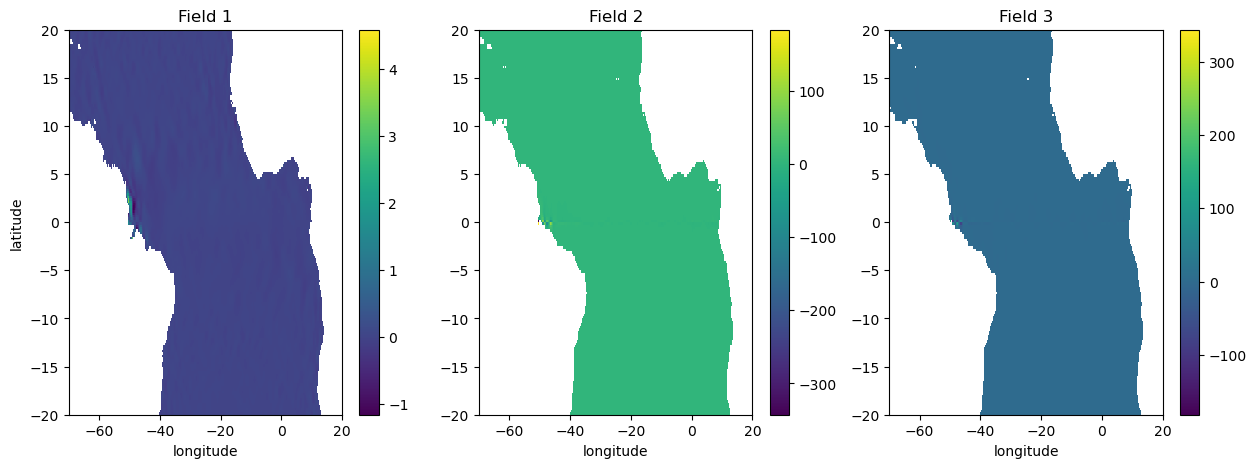

In [25]:
fig = plot(v_curr, advec_u + v_geos, v_curr - advec_u - v_geos)

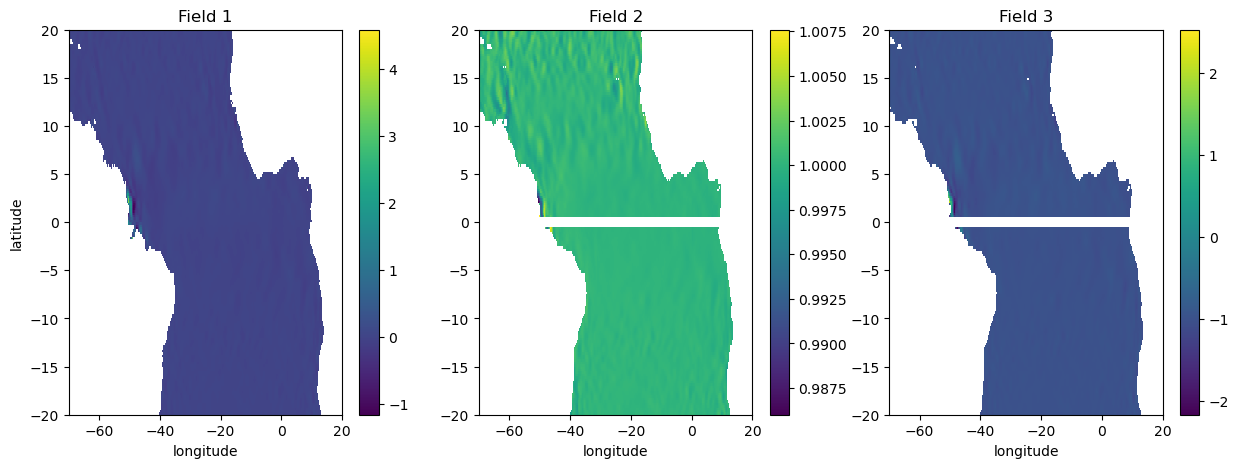

In [26]:
fig = plot(v_curr, advec_u + v_geos_1, v_curr - advec_u - v_geos_1)

In [27]:
advec_u, advec_v = ut.advection(u_curr, v_curr, lon_1, lat_1) 

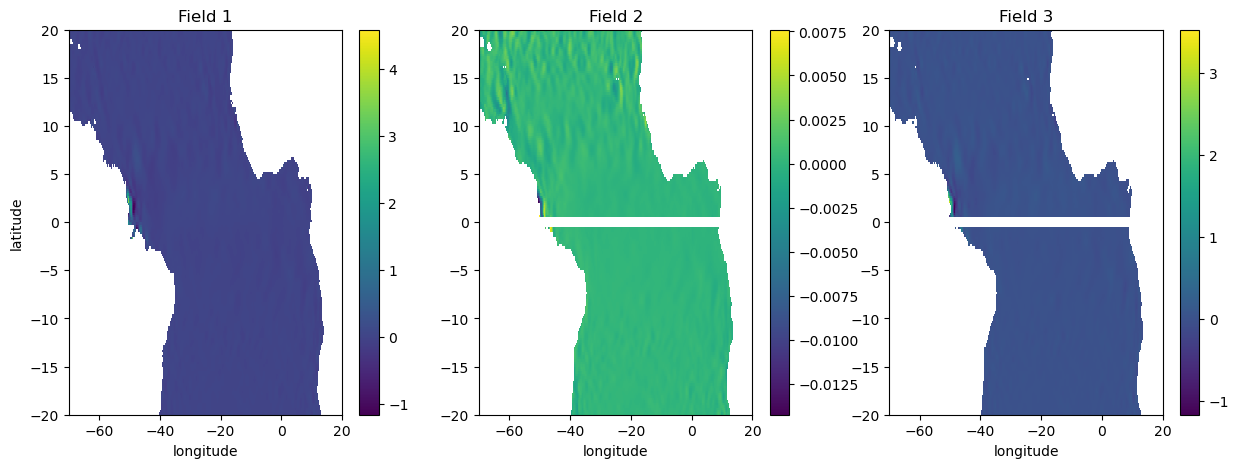

In [28]:
fig = plot(v_curr, advec_u + v_geos_1, v_curr-advec_u-v_geos_1)

In [52]:
coriolis_factor = 2 * 7.2722e-05 * np.sin(lat_1*np.pi/180)
advec_uc, advec_vc = ut.advection(u_curr, v_curr, lon_1, lat_1) / coriolis_factor

In [3]:
## Using the linear approximation to correct the Coriolis parameter at the equator.

In [56]:
import numpy as np

def coriolis_parameter(latitude, latitude_ref, omega):
    """
    Calcul du paramètre de Coriolis en fonction de la latitude à l'aide de l'approximation linéaire.
    
    Paramètres :
        - latitude : Vecteur de latitudes en degrés.
        - latitude_ref : Latitude de référence en degrés.
        - omega : Vitesse angulaire de la Terre en rad/s.
    
    Retourne :
        - Paramètres de Coriolis en fonction des latitudes.
    """
    # Filtrer les latitudes entre -1 et 1 degré
    latitudes_filtrees =np.where((latitudes > -0.5) & (latitudes < 0.5), np.nan, latitudes)
    
    # Calculer les paramètres de Coriolis uniquement pour les latitudes filtrées
    return 2 * omega * np.sin(np.radians(latitude_ref)) + (latitudes_filtrees - latitude_ref) * (2 * omega * np.cos(np.radians(latitude_ref)))

# Exemple d'utilisation
latitude_ref = 45  # Latitude de référence en degrés
omega = 7.2921159e-5  # Vitesse angulaire de la Terre en rad/s

# Vecteur de latitudes à évaluer
latitudes = lat_1

# Calcul des paramètres de Coriolis à l'aide de l'approximation linéaire
parametres_coriolis = coriolis_parameter(latitudes, latitude_ref, omega)

advec_u_1, advec_v_1 = ut.advection(u_curr, v_curr, lon_1, lat_1) / parametres_coriolis 

#  print("Paramètres de Coriolis aux latitudes", latitudes, ":", parametres_coriolis)

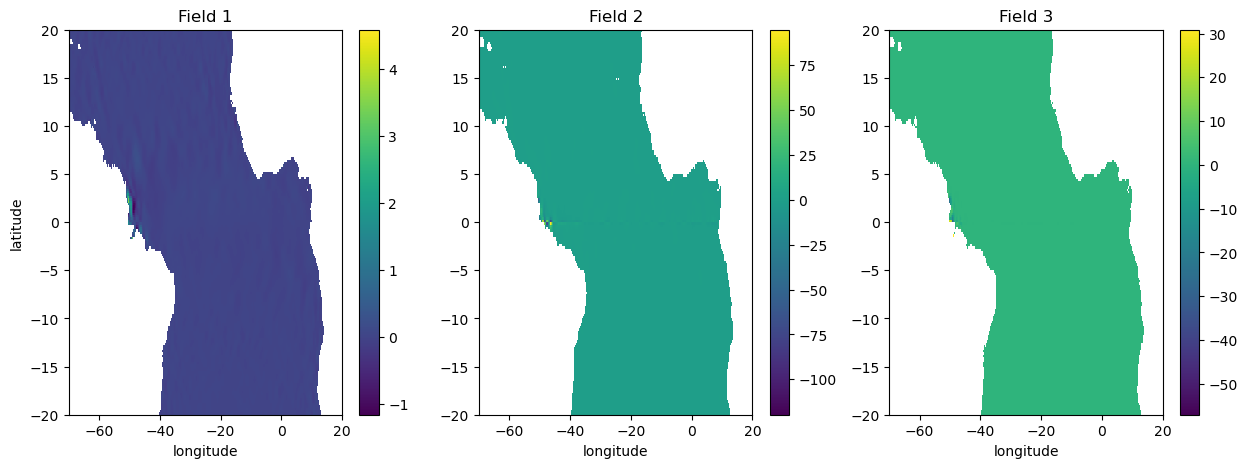

In [55]:
fig = plot(v_curr, advec_uc + v_geos, advec_uc)

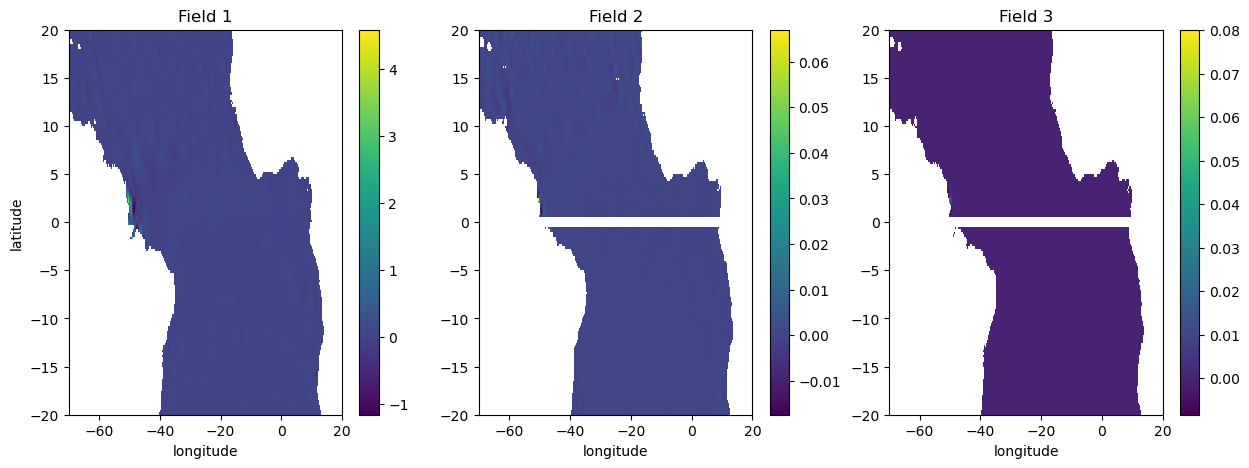

In [57]:
fig = plot(v_curr, advec_u_1 + v_geos_1, advec_u_1)

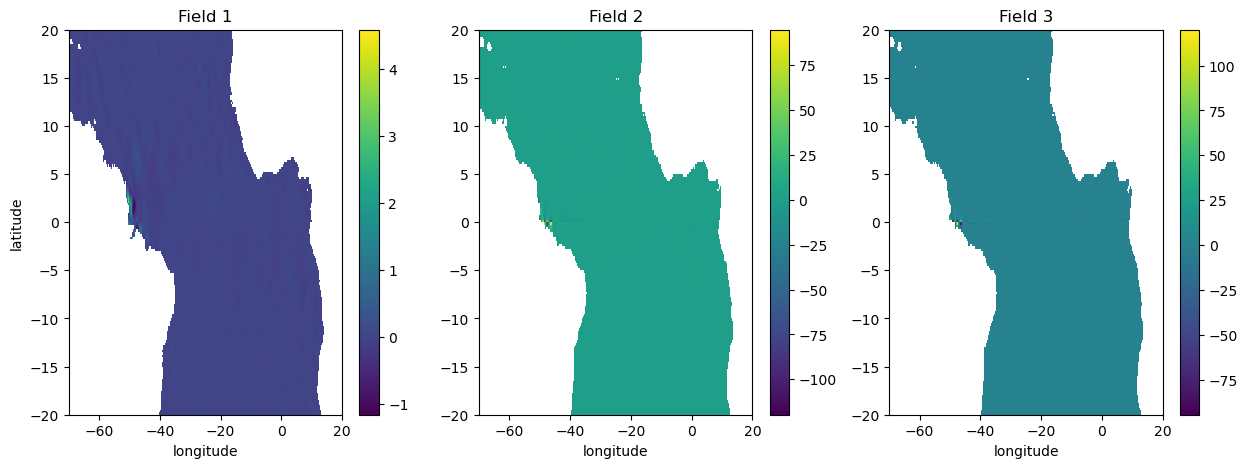

In [58]:
fig = plot(v_curr, advec_uc + v_geos, v_curr - advec_uc - v_geos)

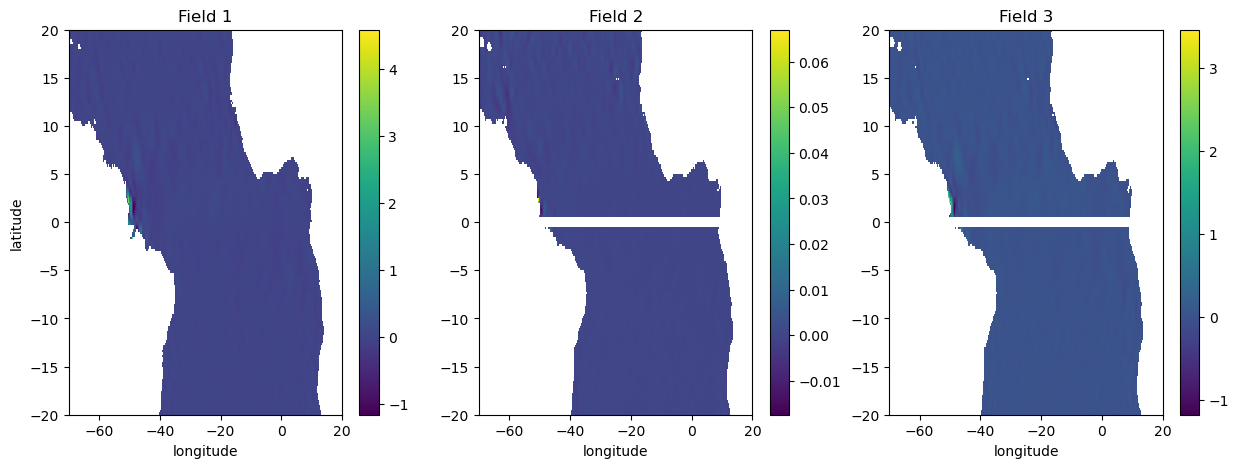

In [59]:
fig = plot(v_curr, advec_u_1 + v_geos_1, v_curr - advec_u_1 - v_geos_1)

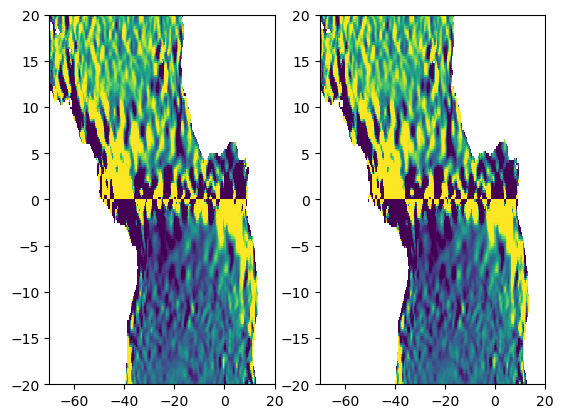

In [60]:
vmin, vmax = -0.05, 0.05
plt.subplot(121)
plt.pcolormesh(lon_1, lat_1, v_curr-advec_uc-v_geos, vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.pcolormesh(lon_1, lat_1, v_curr-v_geos, vmin=vmin, vmax=vmax)       
# plt.colorbar()

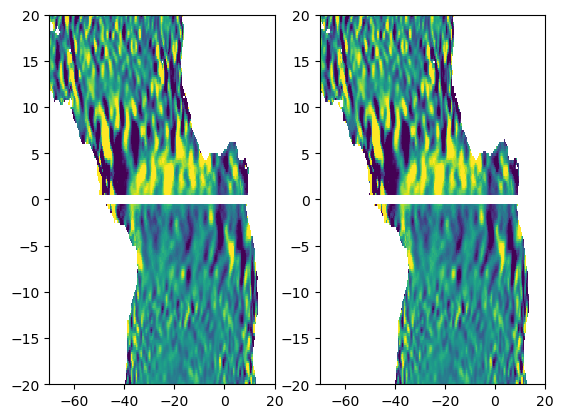

In [61]:
vmin, vmax = -0.05, 0.05
plt.subplot(121)
plt.pcolormesh(lon_1, lat_1, v_curr-advec_u_1-v_geos_1, vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.pcolormesh(lon_1, lat_1, v_curr-v_geos_1, vmin=vmin, vmax=vmax)       
# plt.colorbar()

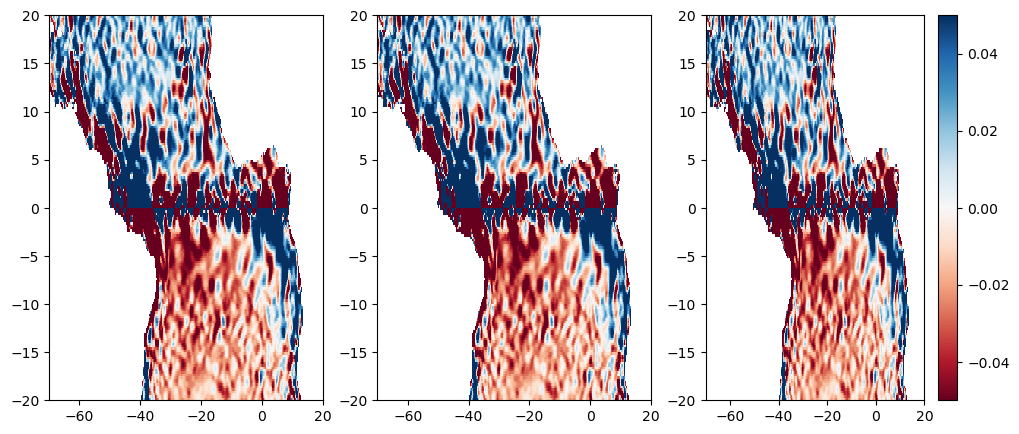

In [62]:
vmin, vmax = -0.05, 0.05
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.pcolormesh(lon_1, lat_1, v_curr-advec_uc-v_geos, cmap='RdBu', vmin=vmin, vmax=vmax)
plt.subplot(132)
plt.pcolormesh(lon_1, lat_1, v_curr-v_geos, cmap='RdBu', vmin=vmin, vmax=vmax)   
plt.subplot(133)
plt.pcolormesh(lon_1, lat_1, v_curr-v_geos, cmap='RdBu', vmin=vmin, vmax=vmax)   
plt.colorbar()

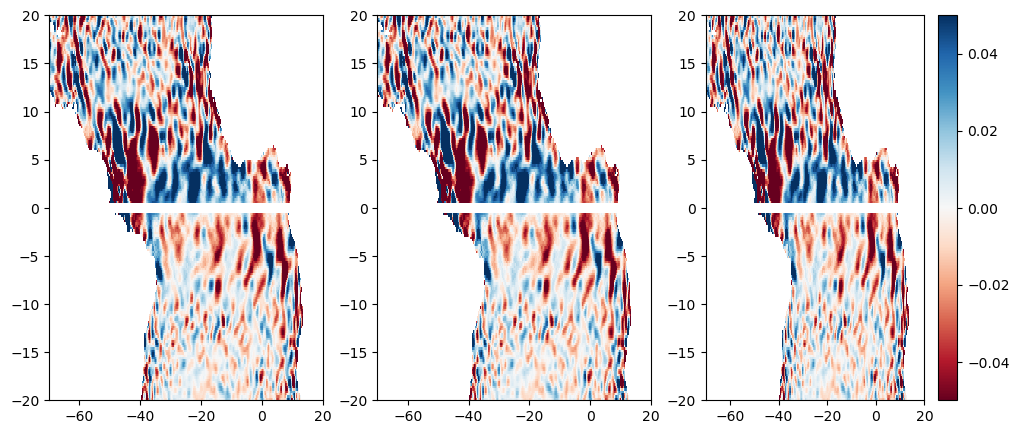

In [65]:
vmin, vmax = -0.05, 0.05
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.pcolormesh(lon_1, lat_1, v_curr-advec_u_1-v_geos_1, cmap='RdBu', vmin=vmin, vmax=vmax)
plt.subplot(132)
plt.pcolormesh(lon_1, lat_1, v_curr-v_geos_1, cmap='RdBu', vmin=vmin, vmax=vmax)   
plt.subplot(133)
plt.pcolormesh(lon_1, lat_1, v_curr-v_geos_1, cmap='RdBu', vmin=vmin, vmax=vmax)   
plt.colorbar()

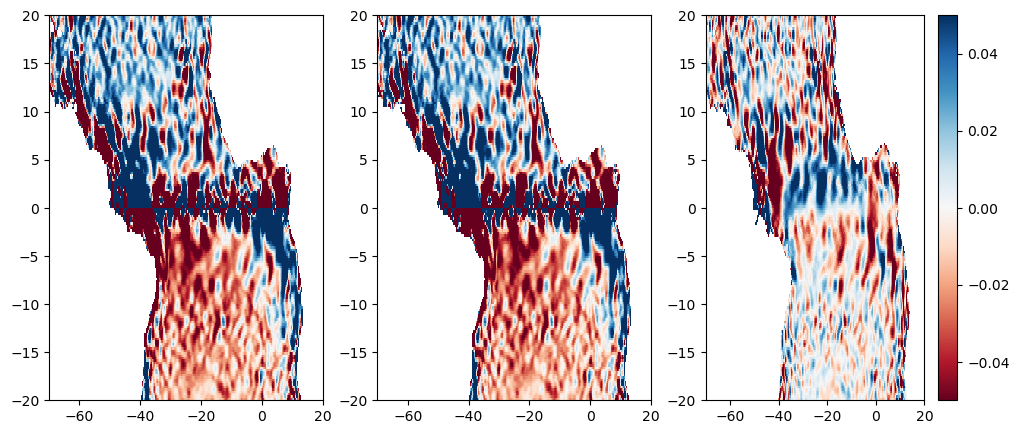

In [66]:
vmin, vmax = -0.05, 0.05
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.pcolormesh(lon_1, lat_1, v_curr-advec_uc-v_geos, cmap='RdBu', vmin=vmin, vmax=vmax)
plt.subplot(132)
plt.pcolormesh(lon_1, lat_1, v_curr-v_geos, cmap='RdBu', vmin=vmin, vmax=vmax)   
plt.subplot(133)
plt.pcolormesh(lon_1, lat_1, v_curr, cmap='RdBu', vmin=vmin, vmax=vmax)   
plt.colorbar()

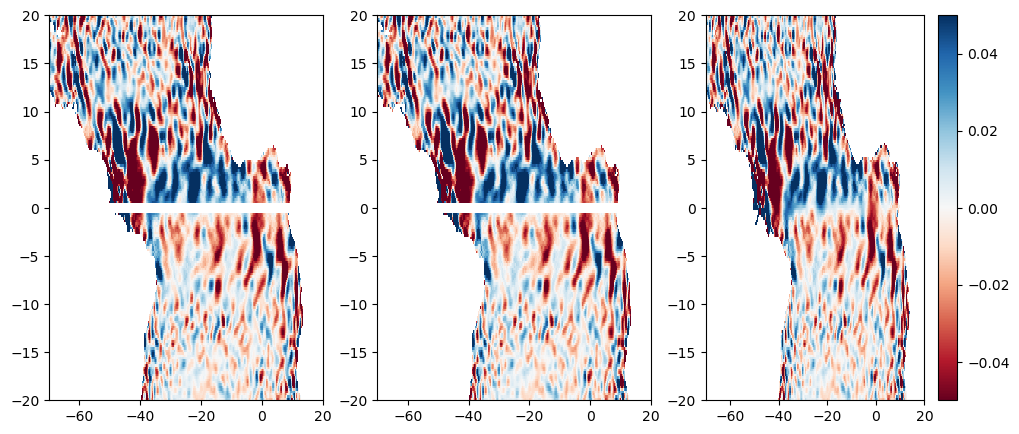

In [67]:
vmin, vmax = -0.05, 0.05
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.pcolormesh(lon_1, lat_1, v_curr-advec_u_1-v_geos_1, cmap='RdBu', vmin=vmin, vmax=vmax)
plt.subplot(132)
plt.pcolormesh(lon_1, lat_1, v_curr-v_geos_1, cmap='RdBu', vmin=vmin, vmax=vmax)   
plt.subplot(133)
plt.pcolormesh(lon_1, lat_1, v_curr, cmap='RdBu', vmin=vmin, vmax=vmax)   
plt.colorbar()

It seems that a very few large values are responsible for extended colorbars... and it is not clear if the differences are small in most of the domain. We can try to re-plot reducing the color interval and using a diverging color scale, with white representing 0. The very dark (gray and red) points indicate values larger (smaller) than vmax (vmin).

Below we also try to design a variable that can reflect the closeness of both terms...

In [68]:
normdiff_u = (u_curr - u_geos + advec_vc)/(u_curr)
normdiff_u[np.where(np.abs(u_curr)<0.01)] = 0

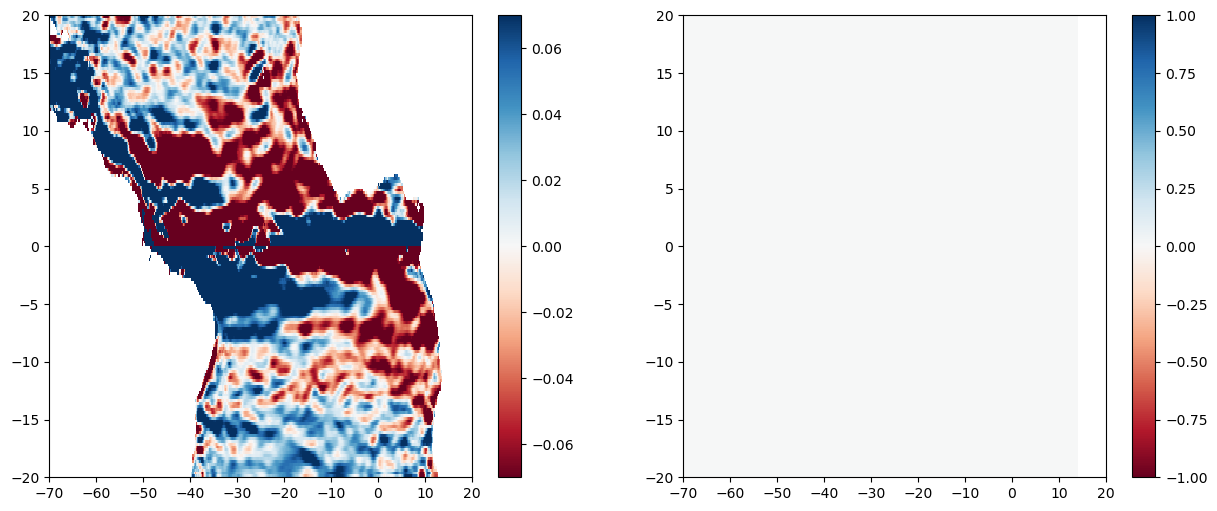

In [69]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.pcolormesh(lon_1,lat_1,u_curr - u_geos + advec_vc, shading='auto', cmap = 'RdBu', vmin = -0.07, vmax = 0.07)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(lon_1,lat_1,normdiff_u, shading='auto', cmap = 'RdBu', vmin = -1, vmax = 1)
plt.colorbar()

In [72]:
normdiff_u = (u_curr - u_geos_1 + advec_v_1)/(u_curr)
normdiff_u[np.where(np.abs(u_curr)<0.01)] = 0

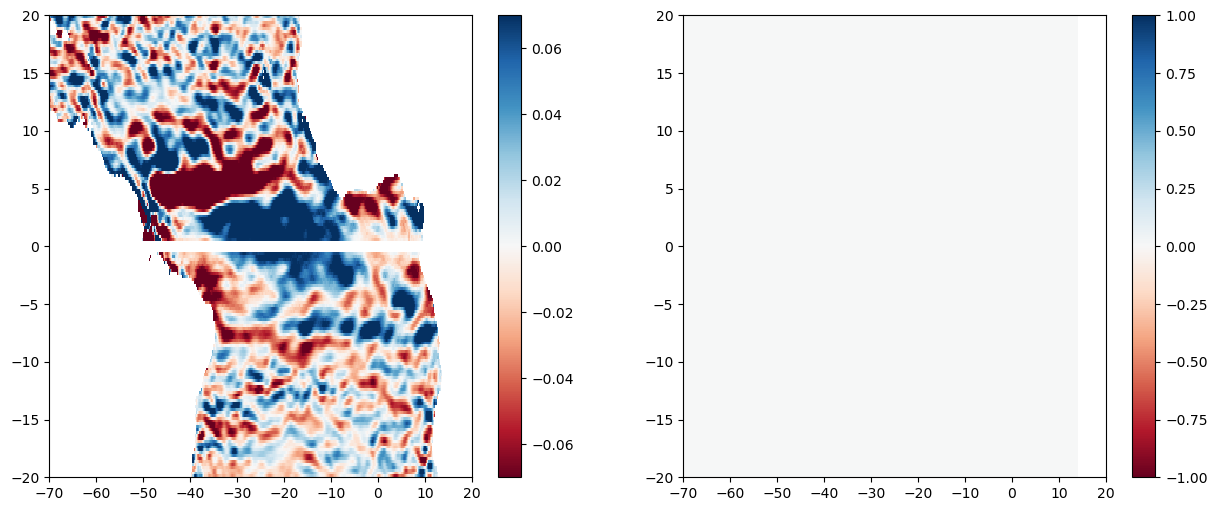

In [73]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.pcolormesh(lon_1,lat_1,u_curr - u_geos_1 + advec_v_1, shading='auto', cmap = 'RdBu', vmin = -0.07, vmax = 0.07)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(lon_1,lat_1,normdiff_u, shading='auto', cmap = 'RdBu', vmin = -1, vmax = 1)
plt.colorbar()